The barebones nearest neighbor ML model performed the best according to our precision metrics.
As such, we're going to refactor the code used in the [exploration](./nearest_neighbor_exploration.ipynb) to accommodate
productionizing this code.

Our goal will be to develop a simple pipeline that we can iterate on to 1) deploy, and 2) retrain our model.

In [14]:
import numpy as np
np.random.seed(42)


NearestNeighbors(metric='cosine')

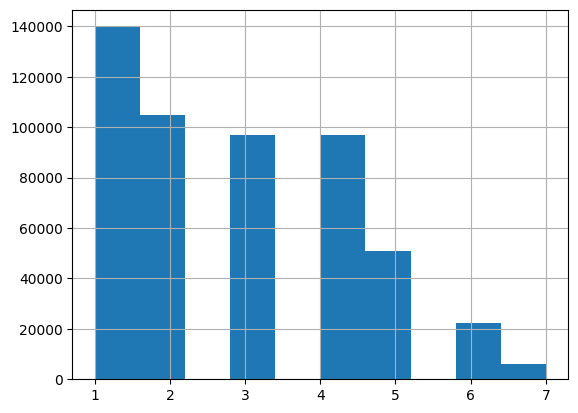

In [15]:
from sklearn.neighbors import NearestNeighbors
from tv_show_recommender.pipelines import get_basic_nn_pipeline
from tv_show_recommender.data.functions import get_stratified_data

train_set, test_set = get_stratified_data();
pipeline = get_basic_nn_pipeline()
df = pipeline.fit_transform(train_set)

transposed_df = df.T

knn = NearestNeighbors(metric='cosine', algorithm='auto')
knn.fit(transposed_df)

In [16]:
from tv_show_recommender.data.functions import get_show_data
from tv_show_recommender.predictors import predict_nearest_neighbor


def get_show_metadata(show_ids = []):
    show_data_df = get_show_data()
    shows_df = show_data_df.loc[show_data_df['show_id'].isin(show_ids)]
    return shows_df['primary_title'].tolist()

# The Wire, DS9, The Sopranos
liked_shows = [306414, 106145, 141842]

similar_show_ids = predict_nearest_neighbor(liked_shows, model=knn, df=df)

show_information = get_show_metadata(similar_show_ids)

print(show_information)

['Breaking Bad', 'Boardwalk Empire', 'Star Trek: The Next Generation', 'Star Trek: Voyager']


In [17]:
# Let's serialize and save the model on our local FS
from os.path import abspath, dirname, join

from joblib import dump
model_filename = 'tv_show_recommender_nn.joblib'

dump(knn, model_filename)

['tv_show_recommender_nn.joblib']

# Now how might our system architecture look like...?

Stage 1:

```mermaid
flowchart

    Lambda(Lambda function)
    ECR(Container registry)
    APIGW(Api Gateway)
    DynamoDB(DynamoDB)
    Client(Client SPA)


    Client --> APIGW
    APIGW --> Client

    APIGW -->|Request| Lambda
    Lambda -->|Response| APIGW
    ECR -->|Pulls| Lambda

    Lambda -->|Writes new data| DynamoDB
    Lambda -->|Reads existing data| DynamoDB
```

Our mode can be version controlled and included in our Docker container during a CI build step. In our Lambda, we can load it from the local Docker FS and use it to make predictions. So, no Sagemaker. The caveat is that retraining must happen on a local machine and requires a redeployment of our Lambda.

Stage 2:

```mermaid
flowchart

    Lambda(Lambda function)
    ECR(Container registry)
    APIGW(Api Gateway)
    DynamoDB(DynamoDB)
    S3(S3)
    Client(Client SPA)
    Cloudwatch(Cloudwatch Event)


    SageMakerEndpoint(SageMaker Serverless Model Endpoint)
    SageMaker(SageMaker retraining)

    Client --> APIGW
    APIGW --> Client

    APIGW -->|Request| Lambda
    Lambda -->|Response| APIGW
    ECR -->|Pulls| Lambda

    Lambda -->|Writes new data| DynamoDB
    Lambda -->|Reads existing data| DynamoDB
    Lambda -->|Delegates model inference| SageMakerEndpoint

    DynamoDB -->|Exports data| S3

    S3 -->|Pulls in data| SageMaker
    SageMaker -->|Deploys new model| SageMakerEndpoint

    Cloudwatch -->|Triggers| SageMaker
```

Later, we can delegate serving the model to SageMaker using their serverless offering. Moreover, we can set up automated workflows to retrain and redeploy the model based on some cloudwatch rule (e.g. once per week, once per month). This will let us integrate new data (e.g., new shows to the dataset, new user like relationships) automatically.

